In [1]:
#Standard python
import numpy as np
import matplotlib.pyplot as plt
from numba import jit 
from tqdm.notebook import trange

#All tensorflow packages 
from tensorflow import convert_to_tensor, GradientTape, reduce_mean, square, reduce_sum, reshape
from tensorflow.math import log as tf_log
from tensorflow.keras.activations import swish, sigmoid
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.initializers import RandomNormal

#Sympy package for coordinate transformations
from sympy import lambdify,Matrix,symbols,atan2,sqrt,sin,cos

## Define System parameters

In [2]:
shape = [400,500]           #(Number of trajectories, Number of timesteps)
dt = 0.004                  #Time step
gamma = np.array([1.0,1.0]) #Friction constant
kT = 1.0                    #Reduced Temperature
const = dt/(4*gamma*kT)     #Prefactor for the loss

#Conservative potential of the 2D system
def calcConservativePotential(r):
    return 2*(6+4*r[...,0]**4 -6*r[...,1]**2 + 3*r[...,1]**4 +10*r[...,0]**2*(r[...,1]**2 - 1))


## Load and visualize the trajectories and the potential energy surface

The trajectory is stored as a numpy matrix of shape $(N_t, N_c, N \times 2$, where is the number of trajectories, $N_c$ is the number of configurations per trajectories and $N$ is the total number of degrees of freedom of the system. The first $N$ colums store the coordinates while the rest of them store the corresponding noises.

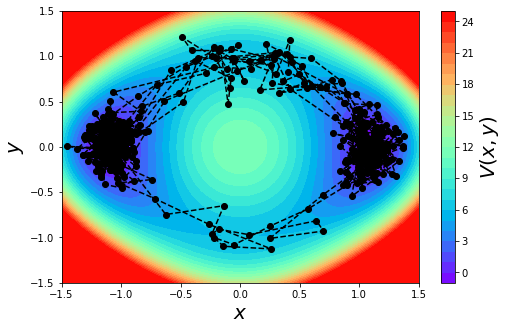

In [8]:
traj = np.load('reactive_trajs_2D.npy')
Ngrids = 100
xs = np.linspace(-1.5,1.5,Ngrids)
ys = np.linspace(-1.5,1.5,Ngrids)
V = np.zeros((Ngrids,Ngrids))
XS,YS = np.meshgrid(xs,ys)
dat = np.concatenate([XS.flatten()[:,None],YS.flatten()[:,None]],axis=-1)
V = calcConservativePotential(dat)
V[V>25] = 25
V = V.reshape(Ngrids,Ngrids)
plt.figure(figsize=(8,5))
plt.contourf(xs,ys,V,levels=25,cmap='rainbow')
for i in range(10):
    plt.plot(traj[i,::10,0],traj[i,::10,1],'--ok')
plt.xlabel('$x$',fontsize=20)
plt.ylabel('$y$',fontsize=20)
cbar = plt.colorbar()
cbar.set_label(label='$V(x,y)$',size=20)


## Prepare trajectories for training

Convert the trajectory to input dataset x and label set y. 

x references a tensor of shape $(N_t \times N_c, N+1)$ tensor, that stores the coordinates of each degree of freedom. The extra column is used for storing the reduced time.

y references a tensor of shape $(N_t \times N_c, N)$ that stores noises to each degree of freedom

In [9]:
#Process raw trajectories
x = traj[:,:,:2].reshape(-1,2)
#Add time information
x = np.concatenate([x, np.tile(np.arange(shape[1])/shape[1], 
                               shape[0])[:,None]],axis=-1)
#Convert to tensors for training
x = convert_to_tensor(x)
#The 'labels' are simply the noises corresponding to each coordinates
y = convert_to_tensor(traj[:,:,2:].reshape(-1,2))

## Framework for performing coordinate transformations

For training on transformed coordinates, the jacobian matrix needs to be stored ahead of time (it can also be computed during training by using tensorflow functions, but that's not necessary for simple systems.

This is done by defining two new tensors, $\tilde x$ (trans_x) and $\tilde y$ (trans_y), where the first one now is a tensor of shape $(N_t \times N_c, \tilde N + 1)$ tensor, that stores all the transformed coordinates and time. Evidently, $\tilde N$ is the number of transformed coordinates.

$\tilde y$ is a tensor of shape $(N_t \times N_c, N, \tilde N + 1)$, where the first column of the label for each configurations contains the noises corresponding to the original degrees of freedom, and the rest $\tilde N$ columns store the partials of all the transformed coordinates w.r.t. original coordinates aka the jacobian matrix.

In [10]:
#Define reference coordinates
sym_x, sym_y = symbols('x y')

#Define transformations to polar coordinates
sym_r = sqrt(sym_x**2 + sym_y**2)
sym_theta = atan2(sym_y,sym_x)

orig_coord  = Matrix([sym_x,sym_y])
trans_coord = Matrix([sym_r, cos(sym_theta), sin(sym_theta)])

#Define functions for computing the transformed coordinates
#and the jacobian matrix
transformFunc = jit(lambdify([[sym_x,sym_y]], trans_coord, 'numpy'))
jacobianFunc  = jit(lambdify([[sym_x,sym_y]], trans_coord.jacobian(orig_coord), 'numpy'))

#Method converts the original training data containing original coordinates
#to transformed coordinates
#The label data y (which originally just stored noises)
#Now additionally contains the jacobian matrix for the transformations
def transformCoordinates(transformFunc, jacobianFunc, x, y):
    #Convert to numpy to enable compatibility with numba functions
    x = x.numpy()
    y = y.numpy()
    #Convert and store the transformed coordinates
    x_trans = np.array([transformFunc(i)[:,0] for i in x[:,:-1]])
    #Create the new labels y, that contains the noises for each
    #original degree of freedom ...
    y_trans = np.zeros((y.shape[0],y.shape[1],x_trans.shape[1]+1))
    y_trans[:,:,0] = y
    #As well as the jacobian matrix
    y_trans[:,:,1:]= np.array([jacobianFunc(i).T for i in x[:,:-1]])
    #As well as the jacobian matrix
    x_trans = np.concatenate([x_trans, x[:,-1:]],axis=-1)
    #Return the new dataset containing information 
    #of the transformed coordinates
    return convert_to_tensor(x_trans), convert_to_tensor(y_trans)

#Load the transformed coordinates
x_trans, y_trans = transformCoordinates(transformFunc, jacobianFunc, x,y)

In [141]:
#Method to performing training on the coordinates and noises
def train(x,y,const,shape,Nepochs=400,learning_rate=0.01,
          split=0.9,transform=False):
    
    #Define the loss function
    if not transform:
        #The loss is simply given by the stochastic action
        def action_loss(eta,lamb):
            return reduce_sum(const *(lamb**2 - 2*lamb*eta),axis=-1)

    else:
        #For training on transformed coordinates, we first compute the 
        #forces on original coordinates, and then compute the stochastic action
        def action_loss(eta,lamb_trans):
            lamb = reduce_sum(lamb_trans[:,None,:] * eta[:,:,1:],axis=-1)
            return reduce_sum(const *(lamb**2 - 2*lamb*eta[:,:,0]),axis=-1)
    
    
    inp_d = x.shape[-1] #Number of inputs
    
    #Define the model for training
    model = Sequential()
    model.add(Input(inp_d))
    initializer = RandomNormal(stddev=0.3)
    #Layer 1
    model.add(Dense(20, input_dim=inp_d,kernel_initializer=initializer,
                    activation=swish))
    #Layer 2
    model.add(Dense(20, input_dim=inp_d,kernel_initializer=initializer,
                    activation=swish))
    #Committor layer
    model.add(Dense(1, input_dim=inp_d,kernel_initializer=initializer,
                    activation=sigmoid,use_bias=False))
    
    opt = Adam(learning_rate=learning_rate) #Optimizer
   
    desc = "Training Loss : {:.3f} | Validation Loss : {:.3f}" #Printing descriptor
    epochs = trange(Nepochs,desc=desc,leave=True) #Define the tqdm iterator
    losses = np.zeros((Nepochs,2)) #Holder for the training and validation loss
    tr_split = int(split*shape[0]) #Number of trajectories used for training
    
    #A boolean array for indexing trajectories for train/validation split
    idx   = np.zeros((shape[0]),dtype=np.bool)
    for epoch in epochs:
        #Shuffle sample for the train-validation split
        idx[:] = False
        tr_idx = np.random.choice(shape[0],tr_split,False)
        idx[tr_idx] = True
        
        #First GradientTape to compute the gradients of the parameters
        with GradientTape() as t2:
            #Second GradientTape to compute the forces
            with GradientTape() as t1:
                t1.watch(x)
                #Compute the negative Control Potential
                ym = 2*kT*tf_log(model(x)) 
            #Compute control forces through automatic differentiation
            lamb = t1.gradient(ym,x)[:,:-1]
            #Compute the loss per trajectory
            loss = reduce_sum(reshape(action_loss(y,lamb),
                             (shape[0],shape[1])),axis=-1)
            #Compute training loss
            tr_loss = reduce_sum(loss[idx])/(shape[0] *split )
            #Compute validation loss
            val_loss= reduce_sum(loss[~idx])/(shape[0]*(1-split))
        #Save validation and training loss
        losses[epoch][0] = tr_loss
        losses[epoch][1] = val_loss
        #Compute the gradient
        grad= t2.gradient(tr_loss,model.trainable_weights)
        #Update the weights
        opt.apply_gradients(zip(grad,model.trainable_weights))
        #Display updated losses
        epochs.set_description(desc.format(losses[epoch][0],losses[epoch][1]),refresh=True)
    return model,losses

#Compute the control forces from the model
def computeLamb(model,x):
    with GradientTape() as t1:
        t1.watch(x)
        ym = 2*kT*tf_log(model(x))
    lamb = t1.gradient(ym,x)[:,:-1].numpy()
    return lamb

#Compute rate decompositions
def computeContributions(model,x,y,transform=False):
    #Total degrees of freedom (excluding time)
    Ndofs = x.shape[-1]-1
    if not transform:
        #Compute the forces on original coordinates
        lamb =  computeLamb(model,x)
        #Compute individual components of the stochastic action for each trajectories
        contribution_cart =  np.sum((const*(-lamb**2 + 2*lamb*y.numpy())
                                    ).reshape(shape[0],shape[1],Ndofs),axis=1)
        return contribution_cart
    
    else:
        #Compute the forces on transformed coordinates
        lamb_trans = computeLamb(model,x)
        #The jacobian matrix and noises are stored in the y tensor
        jacob_mat   = y[:,:,1:].numpy()*np.sqrt(const[None,:,None])
        eta = y[:,:,0].numpy()
        #Compute the 'transformed noises'
        eta_trans   = np.einsum('ij,ijk->ik',eta*np.sqrt(const[None,:]),jacob_mat)
        #Compute the diffusion weighted metric tensor
        metric      = np.einsum('ijk,ijl->ikl',jacob_mat,jacob_mat)
        #Compute the outer product of forces along transformed coordinates
        lamb_trans2 = np.einsum('ij,ik->ijk',lamb_trans,lamb_trans)
        #Compute the diagonal term in the OM action
        lamb_eta  = np.einsum('ij,jk->ijk',lamb_trans*eta_trans,np.eye(Ndofs))
        #Compute the U_jk matrix for all the trajectories
        contribution_trans = np.sum((-metric*lamb_trans2 + 2*lamb_eta).reshape(shape[0], shape[1], 
                                                            Ndofs, Ndofs), axis=1)
        return contribution_trans
        
#Merge rows and columns of the U_jk matrix 
def mergeContribution(matrix, indices):
    new_matrix = np.zeros((matrix.shape))
    for i in range(matrix.shape[-1]):
        for j in range(matrix.shape[-1]):
            new_matrix[...,indices[i],indices[j]] += matrix[...,i,j]
    return new_matrix[...,:indices[-1]+1,:indices[-1]+1]
        

In [155]:
#Perform training on the raw coordinates
model_cart,losses_cart = train(x,y,const,shape)
#Compute rate decompositions for raw coordinates
contribution_cart   = computeContributions(model_cart,x,y)

#Perform training on the polar coordinates
model_polar, losses_polar = train(x_trans,y_trans,const
                                  ,shape,transform=True)
#Compute rate decompositions for polar coordinates (r,cos(θ) and sin(θ))
contribution_polar_trig = computeContributions(model_polar, x_trans, 
                                          y_trans, transform=True)
#Merge the contributions from descriptors cos(θ) and sin(θ)
contribution_polar = mergeContribution(contribution_polar_trig,[0,1,1])

## Visualize training and validation losses

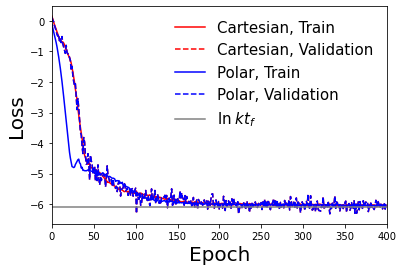

In [156]:
plt.plot(losses_cart[:,0],'-r',label='Cartesian, Train')
plt.plot(losses_cart[:,1],'--r',label='Cartesian, Validation')
plt.plot(losses_polar[:,0],'-b',label='Polar, Train')
plt.plot(losses_cart[:,1],'--b',label='Polar, Validation')
plt.xlim(0,losses_cart.shape[0])
plt.plot([0,losses_cart.shape[0]],[-6.1,-6.1],'gray',label='$\\ln \; kt_f$')
plt.ylabel('Loss',fontsize=20)
plt.xlabel('Epoch',fontsize=20)
plt.legend(fontsize=15,frameon=False)

## Visualize rate decompositions
The relevance of the $i$th original coordinate is given by the average of the first cumulant of the OM action along that coordinate:
### $\langle U^{i}_{\lambda^*} \rangle= \big{\langle} \frac{-[\lambda_i^*]^2 + 2\lambda^*_i\eta}{4\gamma_i k_{\mathrm{B}}T}\big{\rangle} = \big{\langle} \frac{[\lambda_i^*]^2}{4\gamma_i k_{\mathrm{B}}T} \big{\rangle}= \big{\langle} \frac{\lambda_i^* \eta_i}{4\gamma_i k_{\mathrm{B}}T} \big{\rangle}$  
For coordinate transformations, if the orthogonality relation holds i.e. the diffusion weighted metric is diagonal, the decompositions take the form:
### $\langle \tilde U^{j}_{\lambda^*} \rangle=  \sum_{i}^N \frac{-[J_{ij} \tilde\lambda^{*}_j]^2 + 2J_{ij}\tilde\lambda_j^*\eta_i}{4\gamma_i k_{\mathrm{B}}T} = \sum_{i}^N \frac{[J_{ij} \tilde\lambda^{*}_j]^2}{4\gamma_i k_{\mathrm{B}}T} = \sum_{i}^N \frac{J_{ij}\tilde\lambda_j^*\eta_i}{4\gamma_i k_{\mathrm{B}}T}$ 

If the orthogonality condition does not hold, the OM action is coupled by the term $ J_{ij}J_{ik}\tilde \lambda_{j} \tilde \lambda_{k}$. However, one can sum over the coupled terms, and obtain the marginalized action along that coordinate:
### $\langle \bar U_{\lambda^*}^j \rangle=  \sum_{i}^N \frac{-\sum_k ^{\tilde N}[J_{ij} J_{ik} \tilde\lambda^{*}_j \tilde\lambda^{*}_k] + 2J_{ij}\tilde\lambda_j^*\eta_i }{4\gamma_i k_{\mathrm{B}}T} = \sum_{i}^N \sum_k^{\tilde N}\frac{J_{ij} J_{ik} \tilde\lambda^{*}_j \tilde\lambda^{*}_k}{4\gamma_i k_{\mathrm{B}}T} = \sum_{i}^N \frac{J_{ij}\tilde\lambda_j^*\eta_i}{4\gamma_i k_{\mathrm{B}}T}$ 
It can easily be verified that when the orthogonality condition holds, this measure is the same as the previous one.

The distribution of the individual components of the stochastic action for each trajectory is visualized to illustrate these concepts.



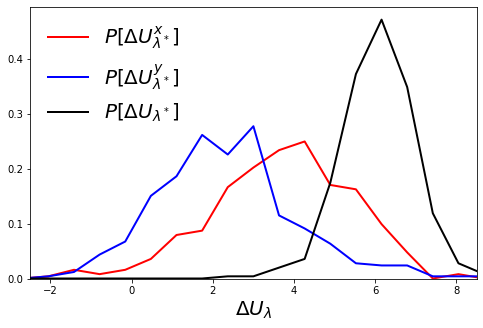

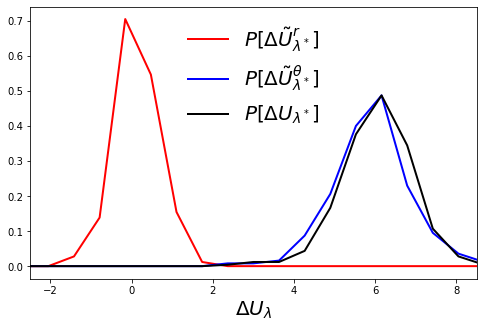

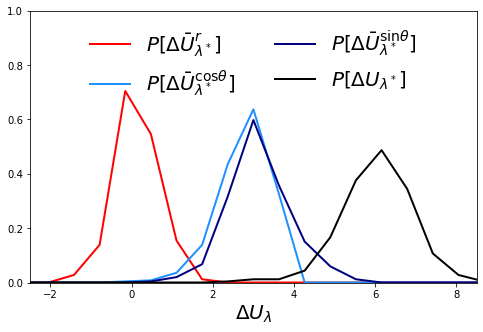

In [186]:
#Rate decompositions for cartesian coordinates
plt.figure(figsize=(8,5))
bins = np.linspace(-3,9,20)
#OM action along x
U_x = np.histogram(contribution_cart[:,0],bins,density=True)[0]
#OM action along y
U_y = np.histogram(contribution_cart[:,1],bins,density=True)[0]
#Total stochastic action. The first cumulant of this quantity is equal to - ln kt_f
U  = np.histogram(np.sum(contribution_cart,axis=-1),bins,density=True)[0]

plt.plot(0.5*(bins[1:]+bins[:-1]),U_x,c='r',lw=2,label='$P[\Delta U_{\\lambda^*}^x]$')
plt.plot(0.5*(bins[1:]+bins[:-1]),U_y,c='b',lw=2,label='$P[\Delta U_{\\lambda^*}^y]$')
plt.plot(0.5*(bins[1:]+bins[:-1]),U,c='k',lw=2,label='$P[\Delta U_{\\lambda^*}]$')
plt.xlabel('$\Delta U_{\lambda}$',fontsize=20)
plt.xlim(-2.5,8.5)
plt.ylim(0)
plt.legend(fontsize=20,frameon=False)

#Rate decompositions for polar coordinates (orthogonal)
plt.figure(figsize=(8,5))
#OM action along r
U_r = np.histogram(contribution_polar[:,0,0],bins,density=True)[0]
#OM action along θ
U_th = np.histogram(contribution_polar[:,1,1],bins,density=True)[0]
#Total stochastic action. The first cumulant of this quantity is equal to - ln kt_f
U = np.histogram(np.sum(contribution_polar,axis=(-1,-2)),bins,density=True)[0]

plt.plot(0.5*(bins[1:]+bins[:-1]),U_r,c='r',lw=2,label='$P[\Delta \\tilde U_{\\lambda^*}^r]$')
plt.plot(0.5*(bins[1:]+bins[:-1]),U_th,c='b',lw=2,label='$P[\Delta \\tilde U_{\\lambda^*}^\\theta]$')
plt.plot(0.5*(bins[1:]+bins[:-1]),U,c='k',lw=2,label='$P[\Delta U_{\\lambda^*}]$')
plt.xlabel('$\Delta U_{\lambda}$',fontsize=20)
plt.xlim(-2.5,8.5)
plt.legend(fontsize=20,frameon=False)


#Rate decompositions for (r,cos(θ) and sin(θ)) (nonorthogonal)
plt.figure(figsize=(8,5))
#OM action along r
U_r = np.histogram(np.sum(contribution_polar_trig[:,0],axis=-1),bins,density=True)[0]
#OM action along cos(θ)
U_cos_th = np.histogram(np.sum(contribution_polar_trig[:,1],axis=-1),bins,density=True)[0]
#OM action along sin(θ)
U_sin_th = np.histogram(np.sum(contribution_polar_trig[:,2],axis=-1),bins,density=True)[0]
#Total stochastic action. The first cumulant of this quantity is equal to - ln kt_f
U  = np.histogram(np.sum(contribution_polar_trig,axis=(-1,-2)),bins,density=True)[0]

plt.plot(0.5*(bins[1:]+bins[:-1]),U_r,c='r',lw=2,label='$P[\Delta \\bar U_{\\lambda^*}^r]$')
plt.plot(0.5*(bins[1:]+bins[:-1]),U_cos_th,c='dodgerblue',lw=2,
         label='$P[\Delta \\bar U_{\\lambda^*}^{\\cos \\theta}]$')
plt.plot(0.5*(bins[1:]+bins[:-1]),U_sin_th,c='navy',lw=2,
         label='$P[\Delta \\bar U_{\\lambda^*}^{\\sin \\theta}]$')
plt.plot(0.5*(bins[1:]+bins[:-1]),U,c='k',lw=2,label='$P[\Delta U_{\\lambda^*}]$')
plt.xlabel('$\Delta U_{\lambda}$',fontsize=20)
plt.xlim(-2.5,8.5)
plt.ylim(0,1)
plt.legend(fontsize=20,frameon=False,ncol=2,loc='upper center')
